# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,GRU,Dense,TimeDistributed
from tensorflow.keras import Input

# Importing DataBase

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_daily = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/salesdaily.csv')

# Importing Pre-Treined models

In [4]:
gru_mrf = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_MostRelavantFeatures.h5') #time_step = 30
gru_mrf_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_MostRelavantFeatures_weekdayMonth.h5')#time_step = 120
gru = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_OneFeature.h5')#time_step = 30
gru_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_weekdayMonth.h5')#time_step = 120
gru_wm_cylic = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/GRU Models/GRU_weekdayMonth_cyclic.h5')#time_step = 120

In [5]:
lstm_mrf_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_multiFeature_mostRelevantFeatures_weekdayMonth.h5')#time_step = 60
lstm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_oneFeature.h5')#time_step = 30
lstm_wm = load_model('/content/drive/My Drive/ML Projects/Pharma Sales/LSTM Models/LSTM_multiFeature_weekdayMonth.h5')#time_step = 60

#Functions

In [6]:
def dataSplit(df,train_percent,val_percent):
  train_limit = int(round((df.shape[0])*train_percent,0))
  val_limit = int(round((df.shape[0])*(train_percent+val_percent),0))
  
  df_train = df[:train_limit]
  df_val = df[train_limit:val_limit]
  df_test = df[val_limit:]

  print(df_train.shape)
  print(df_val.shape)
  print(df_test.shape)

  return df_train,df_val,df_test

In [7]:
def normalizing_data(df_train,df_val,df_test,frange):
  sc = MinMaxScaler(feature_range = frange)
  try:
    aux = df_train.shape[1]
    df_train_norm = sc.fit_transform(df_train)
    df_val_norm = sc.transform(df_val)
    df_test_norm = sc.transform(df_test)

  except:
    df_train = df_train.values.reshape(-1,1)
    df_val = df_val.values.reshape(-1,1)
    df_test = df_test.values.reshape(-1,1)

    
    df_train_norm = sc.fit_transform(df_train)
    df_val_norm = sc.transform(df_val)
    df_test_norm = sc.transform(df_test)

  print(df_train_norm.max(axis=0))
  print(df_train_norm.min(axis=0))
  print('\n')

  print(df_val_norm.max(axis=0))
  print(df_val_norm.min(axis=0))
  print('\n')

  print(df_test_norm.max(axis=0))
  print(df_test_norm.min(axis=0))

  print('-------------------------')

  print(df_train_norm.shape)
  print(df_val_norm.shape)
  print(df_test_norm.shape)
  return df_train_norm,df_val_norm,df_test_norm

In [8]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - future_steps): 
    x_train.append(df_train[i - time_steps : i, :]) 
    y_train.append(df_train[i : i + future_steps, -1 ]) 

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - future_steps):
    x_val.append(df_val[i - time_steps : i, :]) 
    y_val.append(df_val[i : i + future_steps,-1]) 

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - future_steps):
    x_test.append(df_test[i - time_steps : i, :]) 
    y_test.append(df_test[i : i + future_steps,-1]) 

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

  x_train = x_train.astype(np.float32)
  y_train = y_train.astype(np.float32)

  x_val = x_val.astype(np.float32)
  y_val = y_val.astype(np.float32)

  x_test = x_test.astype(np.float32)
  y_test = y_test.astype(np.float32)
  
  return x_train,x_test,x_val,y_train,y_val,y_test

# Colaborative predictions

The main idea it's to use multiple RNN predictions to make a better final prediction. 
This notebook will implement exactly the diagram below:  

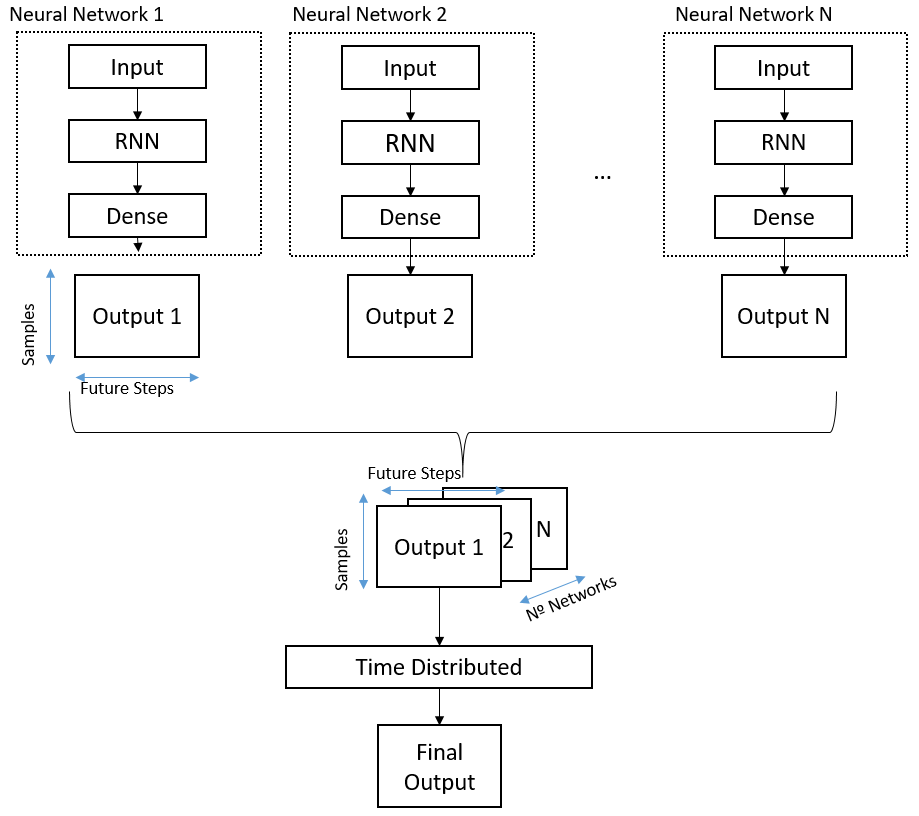

----

The RNN's are pre-treined and have already been imported, the next step it's to prepare the data to create the proposed architecture.


# Data Preparetion

This topic will be divided in two parts:

- Data prep for networks that have been trained with the `same number` of times steps.

- Data prep for networks that have been trained with `differents numbers` of times steps

---

It's important to remember that some networks have been trained with differents types of extra features (they were all trained with the target feature) , so some input maybe differents than others.

## Creating Extra Features

In [9]:
df_daily = df_daily[['datum','Weekday Name','N02BE']]
df_daily.columns = ['data','weekday','N02BE']

df_daily['data'] = pd.to_datetime(df_daily['data'])
df_daily['month'] = df_daily['data'].dt.month
df_daily = df_daily[['weekday','month','N02BE']]

df_daily = pd.concat([pd.get_dummies(df_daily['weekday']),df_daily],axis=1)
dict_ = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df_daily['weekday'].replace(dict_,inplace = True)

df_daily = pd.concat([pd.get_dummies(df_daily['month']),df_daily],axis=1)

df_daily['weekday_sin'] = np.sin(df_daily['weekday']*(2.*np.pi/24))
df_daily['weekday_cos'] = np.cos(df_daily['weekday']*(2.*np.pi/24))
df_daily['month_sin'] = np.sin((df_daily['month']-1)*(2.*np.pi/12))
df_daily['month_cos'] = np.cos((df_daily['month']-1)*(2.*np.pi/12))

df_daily['lag1'] = df_daily['N02BE'].shift(1)
df_daily['lag2'] = df_daily['N02BE'].shift(2)
df_daily['lag3'] = df_daily['N02BE'].shift(3)
df_daily['lag4'] = df_daily['N02BE'].shift(4)
df_daily['lag5'] = df_daily['N02BE'].shift(5)
df_daily['lag6'] = df_daily['N02BE'].shift(6)
df_daily['lag7'] = df_daily['N02BE'].shift(7)
df_daily['lag30'] = df_daily['N02BE'].shift(30)
df_daily['lag60'] = df_daily['N02BE'].shift(60)
df_daily['lag120'] = df_daily['N02BE'].shift(120)
df_daily['lag240'] = df_daily['N02BE'].shift(240)

df_daily['rolling_mean_2'] = df_daily['N02BE'].rolling(window = 2).mean()
df_daily['rolling_mean_3'] = df_daily['N02BE'].rolling(window = 3).mean()
df_daily['rolling_mean_4'] = df_daily['N02BE'].rolling(window = 4).mean()
df_daily['rolling_mean_5'] = df_daily['N02BE'].rolling(window = 5).mean()
df_daily['rolling_mean_6'] = df_daily['N02BE'].rolling(window = 6).mean()
df_daily['rolling_mean_7'] = df_daily['N02BE'].rolling(window = 7).mean()
df_daily['rolling_mean_30'] = df_daily['N02BE'].rolling(window = 30).mean()
df_daily['rolling_mean_60'] = df_daily['N02BE'].rolling(window = 60).mean()
df_daily['rolling_mean_120'] = df_daily['N02BE'].rolling(window = 120).mean()
df_daily['rolling_mean_240'] = df_daily['N02BE'].rolling(window = 240).mean()

df_daily = df_daily[['weekday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','weekday_sin','weekday_cos','month',1,2,3,4,5,6,7,8,9,10,11,12,'month_sin','month_cos',
          'lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag30','lag60','lag120','lag240',
          'rolling_mean_2','rolling_mean_3','rolling_mean_4','rolling_mean_5','rolling_mean_6','rolling_mean_7','rolling_mean_30','rolling_mean_60','rolling_mean_120','rolling_mean_240',
          'N02BE']]

df_daily.fillna(0,inplace = True)

df_daily.head()

,weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday_sin,weekday_cos,month,1,2,3,4,5,6,7,8,9,10,11,12,month_sin,month_cos,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag30,lag60,lag120,lag240,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6,rolling_mean_7,rolling_mean_30,rolling_mean_60,rolling_mean_120,rolling_mean_240,N02BE
0,4,0,0,0,1,0,0,0,0.866025,5.000000e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,32.40
1,5,0,0,0,0,1,0,0,0.965926,2.588190e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,32.40,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.500,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,50.60
2,6,0,0,0,0,0,1,0,1.000000,6.123234e-17,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,50.60,32.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.225,48.283333,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,61.85
3,7,0,0,0,0,0,0,1,0.965926,-2.588190e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,61.85,50.60,32.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.475,51.183333,46.4875,0.00,0.0,0.0,0.0,0.0,0.0,0.0,41.10
4,1,1,0,0,0,0,0,0,0.258819,9.659258e-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,41.10,61.85,50.6,32.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.400,41.550000,43.8125,41.53,0.0,0.0,0.0,0.0,0.0,0.0,21.70


## Same number of times steps 

30 times steps:
- gru_mrf
- gru
- lstm

60 times steps:
- lstm_mrf_wm
- lstm_wm

120 times steps:
- gru_mrf_wm
- gru_wm
- gru_wm_cylic


### Input shaping

#### 30 Times Steps

- gru_mrf

In [10]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily[['lag1','rolling_mean_2','rolling_mean_3','N02BE']],train_percent = 0.7,val_percent = 0.15)
train_gru_mrf,val_gru_mrf,test_gru_mrf = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474, 4)
(316, 4)
(316, 4)
[1. 1. 1. 1.]
[0. 0. 0. 0.]


[0.46335404 0.51821283 0.54192647 0.46335404]
[0.         0.07067853 0.08834426 0.        ]


[0.62173913 0.73377827 0.69222001 0.62173913]
[0.         0.05005562 0.09119407 0.        ]
-------------------------
(1474, 4)
(316, 4)
(316, 4)


In [11]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru_mrf.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru_mrf,df_val = val_gru_mrf,df_test = test_gru_mrf)

# Prediction
x_train_gru_mrf = gru_mrf.predict(x_train)
x_val_gru_mrf = gru_mrf.predict(x_val)
x_test_gru_mrf = gru_mrf.predict(x_test)

- gru

In [12]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_gru,val_gru,test_gru = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [13]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_gru.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_gru,df_val = val_gru,df_test = test_gru)

# Prediction
x_train_gru = gru.predict(x_train)
x_val_gru = gru.predict(x_val)
x_test_gru = gru.predict(x_test)

- lstm

In [14]:
# Spliting and Normalizing
df_train,df_val,df_test = dataSplit(df = df_daily['N02BE'],train_percent = 0.7,val_percent = 0.15)
train_lstm,val_lstm,test_lstm = normalizing_data(df_train,df_val,df_test,frange = (0,1))

(1474,)
(316,)
(316,)
[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


In [15]:
# Regressor
time_steps = 30
future_steps = 5
n_features = train_lstm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = train_lstm,df_val = val_lstm,df_test = test_lstm)

# Prediction
x_train_lstm = lstm.predict(x_train)
x_val_lstm = lstm.predict(x_val)
x_test_lstm = lstm.predict(x_test)

## Reshaping data
 
The outputs predictions from the previous networks will be reshaped according to the figure below  

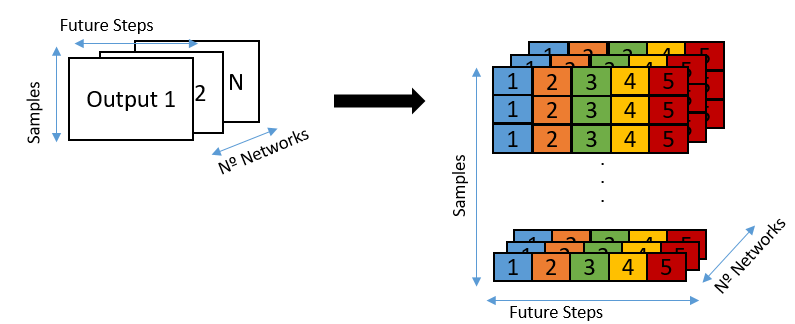


Creating 3D matriz from networks outputs

In [16]:
x_train = np.array([    x_train_gru_mrf, x_train_gru, x_train_lstm     ])
x_val = np.array([    x_val_gru_mrf, x_val_gru, x_val_lstm     ])
x_test = np.array([    x_test_gru_mrf, x_test_gru, x_test_lstm     ])

# y_train = np.array([    y_train_gru_mrf, y_train_gru, y_train_lstm     ])
# y_val = np.array([    y_val_gru_mrf, y_val_gru, y_val_lstm     ])
# y_test = np.array([    y_test_gru_mrf, y_test_gru, y_test_lstm     ])

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('\n')
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3, 1439, 5)
(3, 311, 5)
(3, 311, 5)


(1439, 5)
(311, 5)
(311, 5)



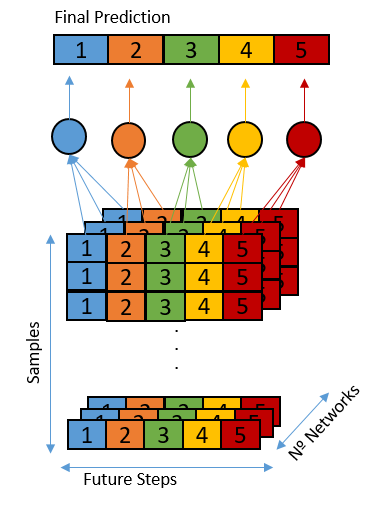

# Creating Model

In [17]:
input_1 = Input(shape=(x_train.shape[0],))
input_2 = Input(shape=(x_train.shape[0],))
input_3 = Input(shape=(x_train.shape[0],))
input_4 = Input(shape=(x_train.shape[0],))
input_5 = Input(shape=(x_train.shape[0],))


output_1 = Dense(1,activation='linear')(input_1)
output_2 = Dense(1,activation='linear')(input_2)
output_3 = Dense(1,activation='linear')(input_3)
output_4 = Dense(1,activation='linear')(input_4)
output_5 = Dense(1,activation='linear')(input_5)

model = Model( inputs = [input_1,input_2,input_3,input_4,input_5], outputs = [output_1,output_2,output_3,output_4,output_5] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

In [18]:
#train
input_1_train = x_train[:,:,0].T
input_2_train = x_train[:,:,1].T
input_3_train = x_train[:,:,2].T
input_4_train = x_train[:,:,3].T
input_5_train = x_train[:,:,4].T

output_1_train = y_train[:,0]
output_2_train = y_train[:,1]
output_3_train = y_train[:,2]
output_4_train = y_train[:,3]
output_5_train = y_train[:,4]

#val
input_1_val = x_val[:,:,0].T
input_2_val = x_val[:,:,1].T
input_3_val = x_val[:,:,2].T
input_4_val = x_val[:,:,3].T
input_5_val = x_val[:,:,4].T

output_1_val = y_val[:,0]
output_2_val = y_val[:,1]
output_3_val = y_val[:,2]
output_4_val = y_val[:,3]
output_5_val = y_val[:,4]

#test
input_1_test = x_test[:,:,0].T
input_2_test = x_test[:,:,1].T
input_3_test = x_test[:,:,2].T
input_4_test = x_test[:,:,3].T
input_5_test = x_test[:,:,4].T

output_1_test = y_test[:,0]
output_2_test = y_test[:,1]
output_3_test = y_test[:,2]
output_4_test = y_test[:,3]
output_5_test = y_test[:,4]


# Final Dense Layer

This layer will recive the prediction from the others network and make a final prediction.

## Trainig Model

In [19]:
model.compile(optimizer='adam',metrics=['mae'],loss='mse')
history = model.fit( [ input_1_train,input_2_train,input_3_train,input_4_train,input_5_train ], [ output_1_train,output_2_train,output_3_train,output_4_train,output_5_train ],
                    validation_data=[ [ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ] ] ,epochs=500,batch_size=32,verbose=0)

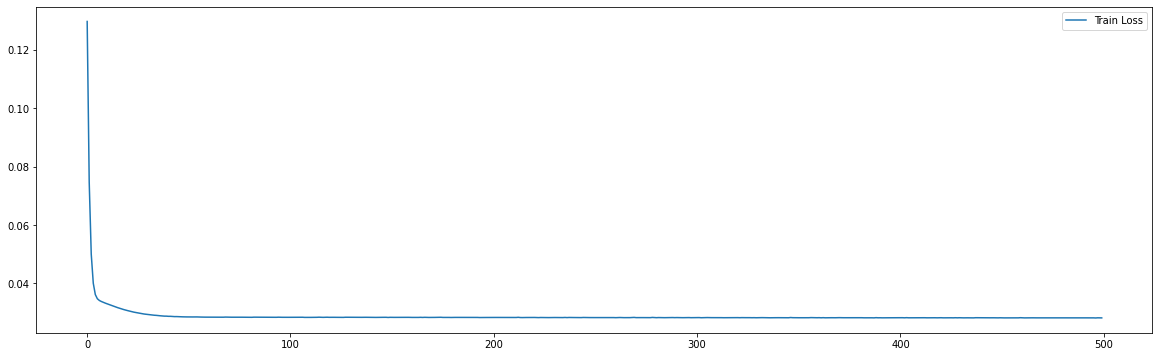

In [27]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.legend(['Train Loss'])

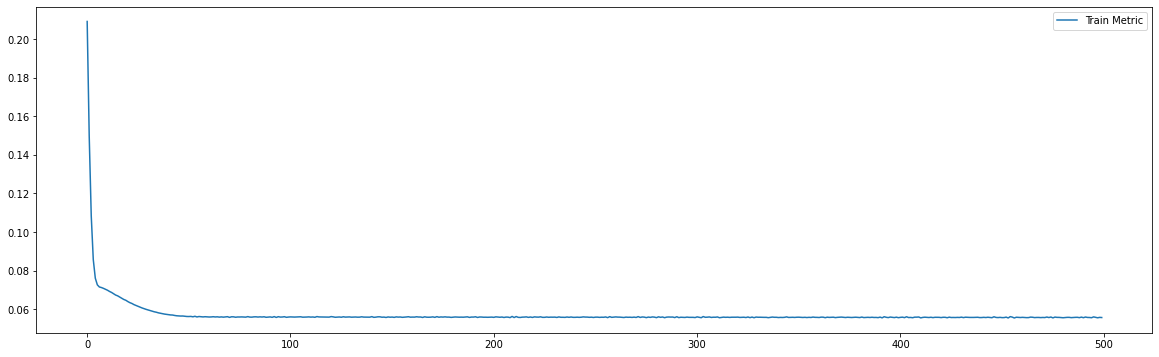

In [26]:
plt.figure(figsize=(20,6))
plt.plot(history.history['dense_mae'])
plt.legend(['Train Metric'])

In [23]:
model.evaluate([ input_1_val,input_2_val,input_3_val,input_4_val,input_5_val ] , [ output_1_val,output_2_val,output_3_val,output_4_val,output_5_val ])

10/10 [==============================] - 0s 4ms/step - loss: 0.0241 - dense_loss: 0.0048 - dense_1_loss: 0.0048 - dense_2_loss: 0.0048 - dense_3_loss: 0.0048 - dense_4_loss: 0.0049 - dense_mae: 0.0542 - dense_1_mae: 0.0542 - dense_2_mae: 0.0547 - dense_3_mae: 0.0553 - dense_4_mae: 0.0556


[0.02406768687069416,
 0.004755478352308273,
 0.0047806911170482635,
 0.004841597285121679,
 0.004802626091986895,
 0.004887295421212912,
 0.05422256514430046,
 0.054249320179224014,
 0.05466373637318611,
 0.05526835098862648,
 0.05557941645383835]

In [25]:
model.evaluate([ input_1_test,input_2_test,input_3_test,input_4_test,input_5_test ] , [ output_1_test,output_2_test,output_3_test,output_4_test,output_5_test ])

10/10 [==============================] - 0s 4ms/step - loss: 0.0338 - dense_loss: 0.0065 - dense_1_loss: 0.0066 - dense_2_loss: 0.0075 - dense_3_loss: 0.0069 - dense_4_loss: 0.0063 - dense_mae: 0.0572 - dense_1_mae: 0.0577 - dense_2_mae: 0.0607 - dense_3_mae: 0.0603 - dense_4_mae: 0.0591


[0.033782169222831726,
 0.006527849473059177,
 0.006571101024746895,
 0.007510652765631676,
 0.006915353238582611,
 0.0062572103925049305,
 0.057221729308366776,
 0.05771554633975029,
 0.060695674270391464,
 0.0603080578148365,
 0.05908425897359848]

In [28]:
(0.0572+0.0577+0.0607+0.0603+0.0591)/5

0.059